# 1. Boiling Points simple estimation

**Task**: Use molecular descriptors (like molecular weight, polarity, and hydrogen bonding) to estimate the boiling point.

**Hint**:

* Larger molecules → Higher BP
* More polar molecules → Higher BP
* More hydrogen bonding (e.g., -OH, -NH2) → Much higher BP

We'll present the function:
BP = a*MolWeight+b*Hydrogen Donors+c*Hydrogen Acceptors+d*log(P)+e

## Obtain data, calculate a, b, c, d, e

Because the database is too big, I take a sample of 500 subtances for better performance.

In [84]:
import pandas as pd
import pubchempy as pcp
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('data_file.csv').drop(columns='Unnamed: 0')

In [6]:
names=list(df['name'])
sample_names=random.sample(names,500)

In [8]:
import concurrent.futures

def get_smiles(name):
    """Trả về SMILES từ tên hợp chất bằng PubChem"""
    compound = pcp.get_compounds(name, 'name')
    return compound[0].isomeric_smiles if compound else None

# Chạy nhiều requests cùng lúc để tăng tốc
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    smiles_list = list(executor.map(get_smiles, sample_names))

# Kiểm tra số lượng hợp chất không tìm thấy
missing = sum(1 for s in smiles_list if s is None)


In [52]:
sample_df=df[df['name'].isin(sample_names)].drop_duplicates(subset=['name'])
sample_df['smiles']=smiles_list
sample_df=sample_df.dropna(subset=['smiles']).reset_index().drop(columns=['index'])

def take_feature(smiles):
    mol=Chem.MolFromSmiles(smiles)
    if mol:
        return {'LogP': Descriptors.MolLogP(mol),
               'HBD': Descriptors.NumHDonors(mol),
               'HBA': Descriptors.NumHAcceptors(mol)}
    return None
feature_df = sample_df['smiles'].dropna().apply(take_feature).apply(pd.Series)
sample_df=pd.concat([sample_df, feature_df], axis=1)

In [62]:
from scipy.optimize import curve_fit
def func(X,a,b,c,d,e):
    LogP, HBD, HBA, molweight=X
    return a*molweight + b*HBD + c*HBA + d*LogP + e
X=np.array([sample_df['LogP'],sample_df['HBD'],sample_df['HBA'],sample_df['molweight']])
Y=np.array(sample_df['boiling point (K)'])
initial_guess=[1,1,1,1,1]

params,_=curve_fit(func, X, Y, p0=initial_guess)
a,b,c,d,e=params
print(a,b,c,d,e)

0.9619464919329938 5.331012983907879 2.6774405557628542 -0.24140365396601982 302.43543739473216


**We findout:**
* a = 0.96
* b = 5.33
* c = 2.68
* d = -0.24
* e = 302.44

In [64]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools

def estimate_boiling_point(smiles):
    mol=Chem.MolFromSmiles(smiles)
    mw=Descriptors.MolWt(mol)
    logp=Descriptors.MolLogP(mol)
    HBD=Descriptors.NumHDonors(mol)
    HBA=Descriptors.NumHAcceptors(mol)
    return a*mw+b*HBD+c*HBA+d*logp+e

# Test with ethanol and benzene
molecules = {"Ethanol": "CCO", "Benzene": "C1=CC=CC=C1"}
for name, smi in molecules.items():
    print(f"{name}: Estimated BP = {estimate_boiling_point(smi):.2f} K")

Ethanol: Estimated BP = 354.76 K
Benzene: Estimated BP = 377.17 K


In [78]:
estimate_df=sample_df['smiles'].apply(estimate_boiling_point).apply(pd.Series)
sample_df=pd.concat([sample_df, estimate_df], axis=1)
estimate_df=sample_df[['name','boiling point (K)',0]]

In [82]:
estimate_df = estimate_df.loc[:, ~estimate_df.columns.duplicated()].rename(columns={0:'Estimate Boiling Point (K)'})
estimate_df

,name,boiling point (K),Estimate Boiling Point (K)
0,(1-ethyloctadecyl)benzene,693.15,435.189626
1,(R)-(-)-2-octanol,448.90,447.646298
2,(S)-(+)-2-amino-1-butanol,446.15,438.375428
3,(S)-(+)-2-butanol,372.60,461.045350
4,(S)-(+)-2-methylbutyric acid,409.77,515.613115
...,...,...,...
376,triethylbenzene; (mixed isomers),490.70,507.884472
377,triethylenediamine,447.15,562.918316
378,trifluoroethene,221.01,427.541990
379,trihexylamine,537.15,418.280345


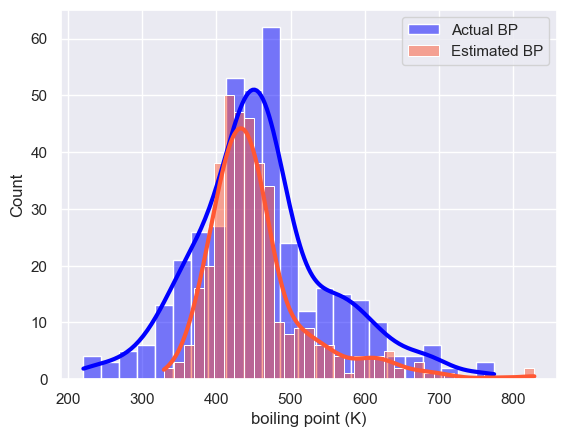

In [125]:
sns.histplot(data=estimate_df['boiling point (K)'], kde=True,label="Actual BP", color='blue', line_kws={'linewidth': 3});
sns.histplot(data=estimate_df['Estimate Boiling Point (K)'], kde=True,label="Estimated BP", color='#FF5733', line_kws={'linewidth': 3});
plt.legend()
plt.show()

**Key Observation** 
* 2 lines are quite separated. It means the predicted figure is far from the exact figure.
Therefore, we shouldn't use this simple function to estimate exact boiling point
* Still, it's a good way to start estimating process

# 2. Lipinski's Rule of Five for Drug-Likeness

**Task**: Check if a molecule follows Lipinski's Rule of Five, which predicts if a compound is likely to be orally active as a drug.

**Rules**:

✅ MW ≤ 500

✅ LogP ≤ 5

✅ ≤ 5 Hydrogen Bond Donors

✅ ≤ 10 Hydrogen Bond Acceptors

In [137]:
def lipinski_check(smiles):
    mol=Chem.MolFromSmiles(smiles)
    mw=Descriptors.MolWt(mol)
    logp=Descriptors.MolLogP(mol)
    HBD=Descriptors.NumHDonors(mol)
    HBA=Descriptors.NumHAcceptors(mol)
    return (mw<=500) and (logp<=5) and (HBD<=5) and (HBA<=10)

# Test with ethanol and benzene
molecules = {"Ethanol": "CCO", "Benzene": "C1=CC=CC=C1"}
for name, smi in molecules.items():
    print(f"{name}: Lipinski Check = {lipinski_check(smi)}")

Ethanol: Lipinski Check = True
Benzene: Lipinski Check = True


In [140]:
sample_df = sample_df.loc[:, ~sample_df.columns.duplicated()].rename(columns={0:'Estimate Boiling Point (K)'})
a = sample_df['smiles'].apply(lipinski_check).apply(pd.Series)
sample_df=pd.concat((sample_df,a),axis=1).rename(columns={0:'Lipinski_check'})

In [162]:
lipinski_df=sample_df[['name','Lipinski_check']]
lipinski_df=lipinski_df['Lipinski_check'].value_counts().to_frame().reset_index()
lipinski_df

,Lipinski_check,count
0,True,341
1,False,40


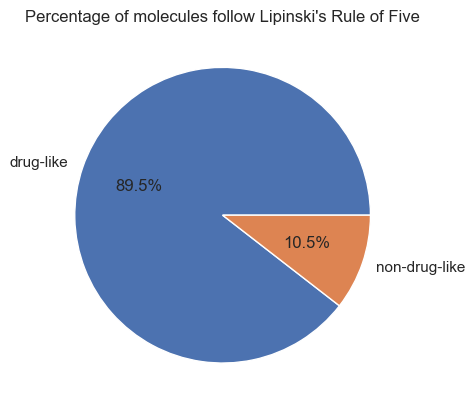

In [224]:
fig, ax=plt.subplots()
ax.pie(lipinski_df['count'], labels=['drug-like','non-drug-like'], autopct='%1.1f%%')
plt.title("Percentage of molecules follow Lipinski's Rule of Five")
plt.show()

**Key Observation**: most of the substances follow Lipinski's Rule of Five, only 10.5% not follow

# 3. Identifying Potentially Reactive Molecules
**Task**: Check for the presence of functional groups that make a molecule chemically reactive. 

In [206]:
from rdkit.Chem import rdMolDescriptors
reactive_groups={
    'Acyl Halide':'CC(=O)Cl',
    'Acid Anhydride':'CC(=O)OC(=O)C',
    'Epoxide':'C1CO1',
    'Aldehyde':'[CX3H1](=O) | [CH2]=O',
    'Ketone': 'CC(=O)C',
    'Thiol (-SH)':'CCS',
    'Primary Amine (-NH₂)':'CN',
    'Secondary Amine (-NHR)':'CN(C)C',
    'Phenol':'c1ccc(cc1)O',
    'Peroxide':'OO',
    'Aziridine (Three-membered nitrogen ring)':'C1CN1',
    'Nitro':'c1ccc(cc1)[N+](=O)[O-]',
    'Sulfonyl (-SO₂R)':'CS(=O)(=O)Cl'
}
def check_reactivity(smiles):
    mol = Chem.MolFromSmiles(smiles)
    results = {}
    for group, pattern in reactive_groups.items():
        subpatterns = pattern.split(" | ")  # Allow multiple SMARTS patterns
        results[group] = any(mol.HasSubstructMatch(Chem.MolFromSmarts(p)) for p in subpatterns)
    return [i for i in results.keys() if results[i]]

# Test with reactive molecules
molecules = {"Formaldehyde": "C=O", "Ethylene Oxide": "C1CO1", "Hydrogen Peroxide": "OO"}
for name, smi in molecules.items():
    print(f"{name}: {check_reactivity(smi)}")

Formaldehyde: ['Aldehyde']
Ethylene Oxide: ['Epoxide']
Hydrogen Peroxide: ['Peroxide']


In [210]:
react_check_df=sample_df['smiles'].apply(check_reactivity).apply(pd.Series)
sample_df=pd.concat([sample_df,react_check_df], axis=1).rename(columns={0:'Reactivity'})

In [211]:
react_df=sample_df[['name','Reactivity']]

In [212]:
react_df

,name,Reactivity
0,(1-ethyloctadecyl)benzene,NaN
1,(R)-(-)-2-octanol,Primary Amine (-NH₂)
2,(S)-(+)-2-amino-1-butanol,NaN
3,(S)-(+)-2-butanol,Primary Amine (-NH₂)
4,(S)-(+)-2-methylbutyric acid,NaN
...,...,...
376,triethylbenzene; (mixed isomers),Phenol
377,triethylenediamine,Primary Amine (-NH₂)
378,trifluoroethene,NaN
379,trihexylamine,Thiol (-SH)


In [223]:
stats= react_df['Reactivity'].value_counts().to_frame().reset_index()
stats['Percentage']=round(stats['count']/381*100,2)
stats

,Reactivity,count,Percentage
0,Primary Amine (-NH₂),28,7.35
1,Phenol,14,3.67
2,Aldehyde,8,2.10
3,Thiol (-SH),8,2.10
4,Ketone,5,1.31
5,Epoxide,1,0.26
6,Peroxide,1,0.26


**Key Observations**
- **Primary Amines (-NH₂)** are the most abundant, making up **7.35%** of the total dataset.  
- **Phenols** and **Aldehydes** appear moderately frequently (**3.67%** and **2.10%**, respectively).  
- **Rare Functional Groups**: Epoxide and Peroxide are the least represented, each at **0.26%**.  
- The dataset suggests a strong prevalence of amine-containing compounds, potentially due to their importance in biochemical and pharmaceutical applications.  
